In [9]:
import librosa


# 1. Get the file path to an included audio example

filename = "wavs_aligned/09.wav"



# 2. Load the audio as a waveform `y`

#    Store the sampling rate as `sr`

y, sr = librosa.load(filename)


# 3. Run the default beat tracker

tempo, beat_frames = librosa.beat.beat_track(y=y, sr=sr)


print('Estimated tempo: {:.2f} beats per minute'.format(tempo))


# 4. Convert the frame indices of beat events into timestamps

beat_times = librosa.frames_to_time(beat_frames, sr=sr)

Estimated tempo: 143.55 beats per minute


In [10]:
# Feature extraction example

import numpy as np

import librosa


# Load the example clip

y, sr = librosa.load(filename)


# Set the hop length; at 22050 Hz, 512 samples ~= 23ms

hop_length = 512


# Separate harmonics and percussives into two waveforms

y_harmonic, y_percussive = librosa.effects.hpss(y)


# Beat track on the percussive signal

tempo, beat_frames = librosa.beat.beat_track(y=y_percussive,

                                             sr=sr)


# Compute MFCC features from the raw signal

mfcc = librosa.feature.mfcc(y=y, sr=sr, hop_length=hop_length, n_mfcc=13)


# And the first-order differences (delta features)

mfcc_delta = librosa.feature.delta(mfcc)


# Stack and synchronize between beat events

# This time, we'll use the mean value (default) instead of median

beat_mfcc_delta = librosa.util.sync(np.vstack([mfcc, mfcc_delta]),

                                    beat_frames)


# Compute chroma features from the harmonic signal

chromagram = librosa.feature.chroma_cqt(y=y_harmonic,

                                        sr=sr)


# Aggregate chroma features between beat events

# We'll use the median value of each feature between beat frames

beat_chroma = librosa.util.sync(chromagram,

                                beat_frames,

                                aggregate=np.median)


# Finally, stack all beat-synchronous features together

beat_features = np.vstack([beat_chroma, beat_mfcc_delta])

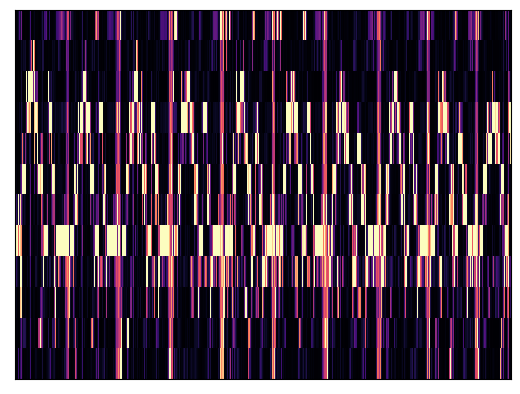

In [20]:
import librosa.display
g1 = librosa.display.specshow(chromagram)

#g2 = librosa.display.specshow(beat_chroma)
#g3 = librosa.display.specshow(beat_features)


In [18]:
# Compute local onset autocorrelation

y, sr = librosa.load(filename, duration=30)

hop_length = 512

oenv = librosa.onset.onset_strength(y=y, sr=sr, hop_length=hop_length)

tempogram = librosa.feature.tempogram(onset_envelope=oenv, sr=sr,

                                      hop_length=hop_length)

# Compute global onset autocorrelation

ac_global = librosa.autocorrelate(oenv, max_size=tempogram.shape[0])

ac_global = librosa.util.normalize(ac_global)

# Estimate the global tempo for display purposes

tempo = librosa.beat.tempo(onset_envelope=oenv, sr=sr,

                           hop_length=hop_length)[0]

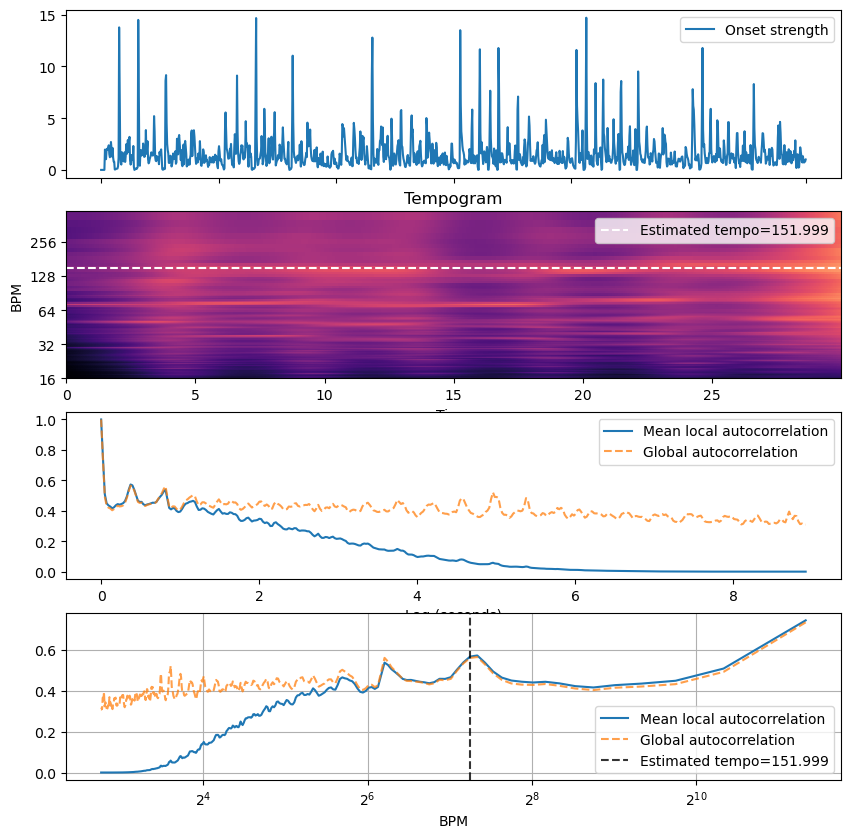

In [19]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=4, figsize=(10, 10))

times = librosa.times_like(oenv, sr=sr, hop_length=hop_length)

ax[0].plot(times, oenv, label='Onset strength')

ax[0].label_outer()

ax[0].legend(frameon=True)

librosa.display.specshow(tempogram, sr=sr, hop_length=hop_length,

                         x_axis='time', y_axis='tempo', cmap='magma',

                         ax=ax[1])

ax[1].axhline(tempo, color='w', linestyle='--', alpha=1,

            label='Estimated tempo={:g}'.format(tempo))

ax[1].legend(loc='upper right')

ax[1].set(title='Tempogram')

x = np.linspace(0, tempogram.shape[0] * float(hop_length) / sr,

                num=tempogram.shape[0])

ax[2].plot(x, np.mean(tempogram, axis=1), label='Mean local autocorrelation')

ax[2].plot(x, ac_global, '--', alpha=0.75, label='Global autocorrelation')

ax[2].set(xlabel='Lag (seconds)')

ax[2].legend(frameon=True)

freqs = librosa.tempo_frequencies(tempogram.shape[0], hop_length=hop_length, sr=sr)

ax[3].semilogx(freqs[1:], np.mean(tempogram[1:], axis=1),

             label='Mean local autocorrelation', base=2)

ax[3].semilogx(freqs[1:], ac_global[1:], '--', alpha=0.75,

             label='Global autocorrelation', base=2)

ax[3].axvline(tempo, color='black', linestyle='--', alpha=.8,

            label='Estimated tempo={:g}'.format(tempo))

ax[3].legend(frameon=True)

ax[3].set(xlabel='BPM')

ax[3].grid(True)

In [26]:
y, sr = librosa.load(filename, duration=15)

chroma = librosa.feature.chroma_cqt(y=y, sr=sr)

bounds = librosa.segment.agglomerative(chroma, 20)

bound_times = librosa.frames_to_time(bounds, sr=sr)

bound_times

array([ 0.        ,  0.69659864,  1.09133787,  2.22911565,  2.69351474,
        4.99229025,  5.2244898 ,  5.7353288 ,  6.10684807,  7.33750567,
        7.59292517,  8.08054422,  8.7539229 ,  9.75238095, 10.17034014,
       11.02947846, 12.30657596, 13.18893424, 13.83909297, 14.81433107])

[Text(0.5, 1.0, 'Power spectrogram')]

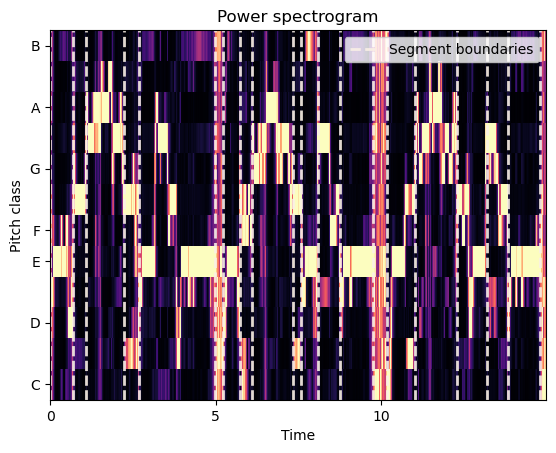

In [27]:
import matplotlib.pyplot as plt

import matplotlib.transforms as mpt

fig, ax = plt.subplots()

trans = mpt.blended_transform_factory(

            ax.transData, ax.transAxes)

librosa.display.specshow(chroma, y_axis='chroma', x_axis='time', ax=ax)

ax.vlines(bound_times, 0, 1, color='linen', linestyle='--',

          linewidth=2, alpha=0.9, label='Segment boundaries',

          transform=trans)

ax.legend()

ax.set(title='Power spectrogram')

In [37]:
y, sr = librosa.load(filename)

onset_env = librosa.onset.onset_strength(y=y, sr=sr)

pulse = librosa.beat.plp(onset_envelope=onset_env, sr=sr)

# Or compute pulse with an alternate prior, like log-normal

import scipy.stats

prior = scipy.stats.lognorm(loc=np.log(120), scale=120, s=1)

pulse_lognorm = librosa.beat.plp(onset_envelope=onset_env, sr=sr,

                                 prior=prior)

melspec = librosa.feature.melspectrogram(y=y, sr=sr)

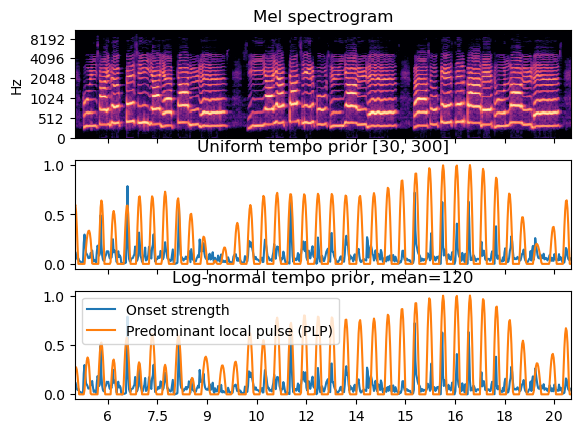

In [38]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=3, sharex=True)

librosa.display.specshow(librosa.power_to_db(melspec,

                                             ref=np.max),

                         x_axis='time', y_axis='mel', ax=ax[0])

ax[0].set(title='Mel spectrogram')

ax[0].label_outer()

ax[1].plot(librosa.times_like(onset_env),

         librosa.util.normalize(onset_env),

         label='Onset strength')

ax[1].plot(librosa.times_like(pulse),

         librosa.util.normalize(pulse),

         label='Predominant local pulse (PLP)')

ax[1].set(title='Uniform tempo prior [30, 300]')

ax[1].label_outer()

ax[2].plot(librosa.times_like(onset_env),

         librosa.util.normalize(onset_env),

         label='Onset strength')

ax[2].plot(librosa.times_like(pulse_lognorm),

         librosa.util.normalize(pulse_lognorm),

         label='Predominant local pulse (PLP)')

ax[2].set(title='Log-normal tempo prior, mean=120', xlim=[5, 20])

ax[2].legend()

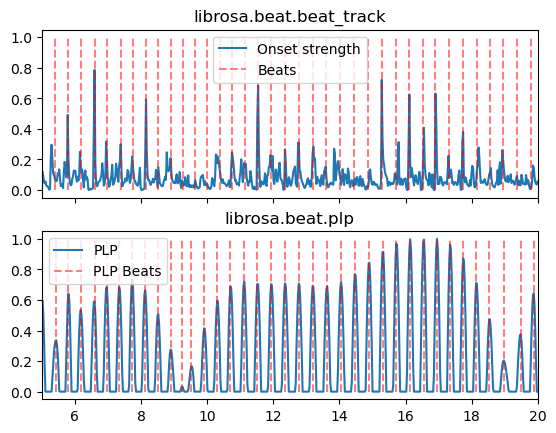

In [39]:
tempo, beats = librosa.beat.beat_track(onset_envelope=onset_env)

beats_plp = np.flatnonzero(librosa.util.localmax(pulse))

import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=2, sharex=True, sharey=True)

times = librosa.times_like(onset_env, sr=sr)

ax[0].plot(times, librosa.util.normalize(onset_env),

         label='Onset strength')

ax[0].vlines(times[beats], 0, 1, alpha=0.5, color='r',

           linestyle='--', label='Beats')

ax[0].legend()

ax[0].set(title='librosa.beat.beat_track')

ax[0].label_outer()

# Limit the plot to a 15-second window

times = librosa.times_like(pulse, sr=sr)

ax[1].plot(times, librosa.util.normalize(pulse),

         label='PLP')

ax[1].vlines(times[beats_plp], 0, 1, alpha=0.5, color='r',

           linestyle='--', label='PLP Beats')

ax[1].legend()

ax[1].set(title='librosa.beat.plp', xlim=[5, 20])

ax[1].xaxis.set_major_formatter(librosa.display.TimeFormatter())

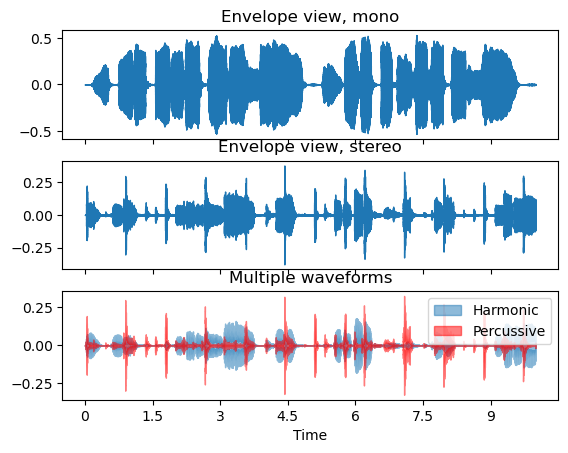

In [35]:
import matplotlib.pyplot as plt

y, sr = librosa.load(filename, duration=10)

fig, ax = plt.subplots(nrows=3, sharex=True)

librosa.display.waveshow(y, sr=sr, ax=ax[0])

ax[0].set(title='Envelope view, mono')

ax[0].label_outer()

y, sr = librosa.load(librosa.ex('choice', hq=True), mono=False, duration=10)

librosa.display.waveshow(y, sr=sr, ax=ax[1])

ax[1].set(title='Envelope view, stereo')

ax[1].label_outer()

y, sr = librosa.load(librosa.ex('choice'), duration=10)

y_harm, y_perc = librosa.effects.hpss(y)

librosa.display.waveshow(y_harm, sr=sr, alpha=0.5, ax=ax[2], label='Harmonic')

librosa.display.waveshow(y_perc, sr=sr, color='r', alpha=0.5, ax=ax[2], label='Percussive')

ax[2].set(title='Multiple waveforms')

ax[2].legend()

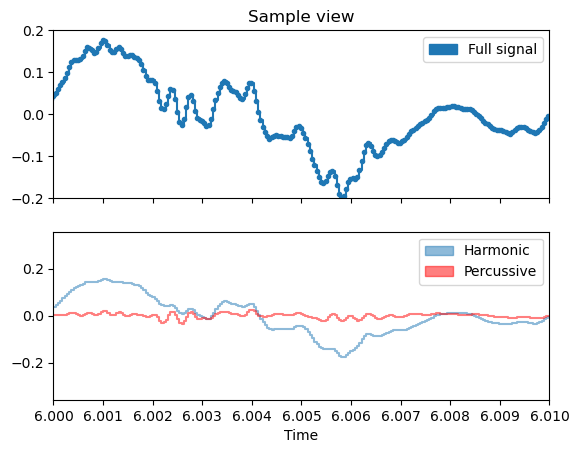

In [36]:
fig, (ax, ax2) = plt.subplots(nrows=2, sharex=True)

ax.set(xlim=[6.0, 6.01], title='Sample view', ylim=[-0.2, 0.2])

librosa.display.waveshow(y, sr=sr, ax=ax, marker='.', label='Full signal')

librosa.display.waveshow(y_harm, sr=sr, alpha=0.5, ax=ax2, label='Harmonic')

librosa.display.waveshow(y_perc, sr=sr, color='r', alpha=0.5, ax=ax2, label='Percussive')

ax.label_outer()

ax.legend()

ax2.legend()

In [45]:
# Sonify detected beat events

y, sr = librosa.load(filename, duration = 30)

tempo, beats = librosa.beat.beat_track(y=y, sr=sr)

y_beats = librosa.clicks(frames=beats, sr=sr)



Text(0.5, 1.0, '')

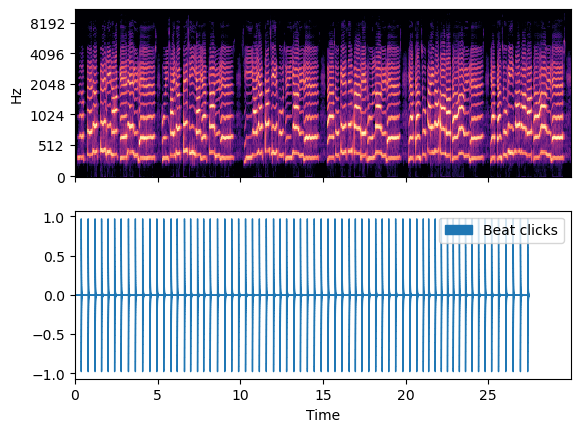

In [46]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=2, sharex=True)

S = librosa.feature.melspectrogram(y=y, sr=sr)

librosa.display.specshow(librosa.power_to_db(S, ref=np.max),

                         x_axis='time', y_axis='mel', ax=ax[0])

librosa.display.waveshow(y_beats, sr=sr, label='Beat clicks',

                         ax=ax[1])

ax[1].legend()

ax[0].label_outer()

ax[0].set_title(None)